# Implementing the U-Net Architecture
The paper uses a U-Net architecture for doing the image inpainting. We've implemented this in `libs/unet.py` module, and we will review it here.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
#!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
#!apt-get update -qq 2>&1 > /dev/null
#!apt-get -y install -qq google-drive-ocamlfuse fuse
#from google.colab import auth
#auth.authenticate_user()
#from oauth2client.client import GoogleCredentials
#creds = GoogleCredentials.get_application_default()
#import getpass
#!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
#vcode = getpass.getpass()
#!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
#!cp -f ~/.gdfuse/default/config config
#!sed -i -e "s/^root_folder=$/root_folder=1guochIx5hAQvrZg20ult-PnKaONAPdm6/" config

#!mkdir -p drive
#!google-drive-ocamlfuse -config ./config -cc drive

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')



import gc
from copy import deepcopy
import cv2
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

import matplotlib
import matplotlib.pyplot as plt

from libs.util import random_mask
from libs.pconv_model import PConvUnet

# Settings
MAX_BATCH_SIZE = 128

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [3]:
import gc
import datetime

import pandas as pd
import numpy as np

from copy import deepcopy
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras import backend as K

import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output

from libs.pconv_model import PConvUnet
from libs.util import random_mask

%load_ext autoreload
%autoreload 2
plt.ioff()

# SETTINGS
TRAIN_DIR = "drive/My Drive/Colab Notebooks/data/hotcake/trainfolder(hot)"
TEST_DIR = "drive/My Drive/Colab Notebooks/data/hotcake/testfolder(hot)"
VAL_DIR = "drive/My Drive/Colab Notebooks/data/hotcake/validationfolder(hot)"

BATCH_SIZE = 4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
class DataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)
        while True:
            
            # Get augmentend image samples
            ori = next(generator)

            # Get masks for each image sample
            mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori
            
# Create training generator
train_datagen = DataGenerator(  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(256, 256), batch_size=BATCH_SIZE
)
# Create validation generator
val_datagen = DataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR, target_size=(256, 256), batch_size=BATCH_SIZE, seed=1
)

# Create testing generator
test_datagen = DataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(256, 256), batch_size=BATCH_SIZE, seed=1
)

Found 56 images belonging to 1 classes.


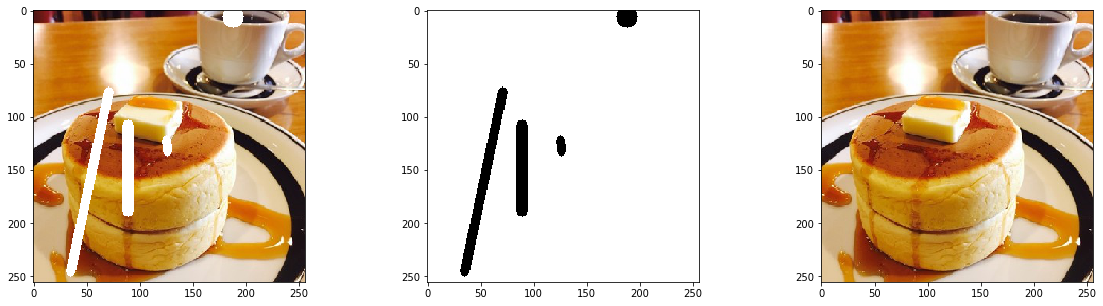

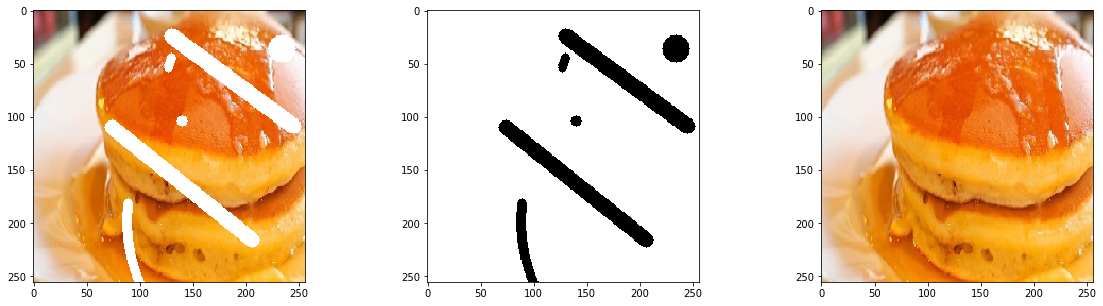

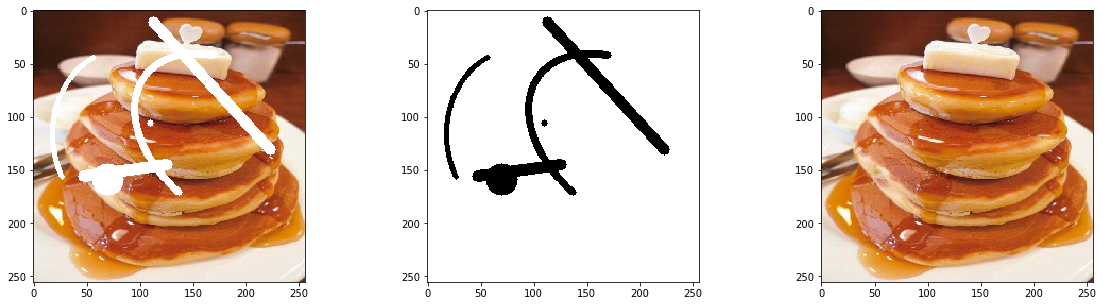

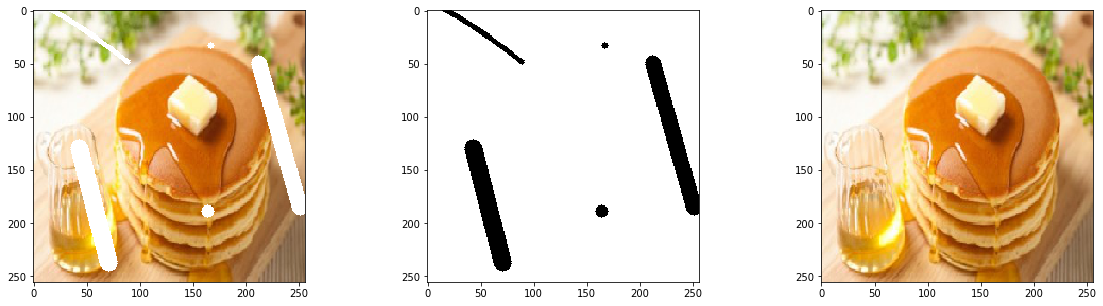

In [5]:

# Pick out an example
test_data = next(test_generator)
(masked, mask), ori = test_data

# Show side by side
for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    plt.show()

In [0]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
                
        plt.savefig(r'drive/My Drive/Colab Notebooks/data/hotcake_samples/img_{}_{}.png'.format(i, pred_time))
        plt.close()

In [0]:
# Instantiate the model
model = PConvUnet(weight_filepath='drive/My Drive/Colab Notebooks/data/logs(hot)/')
model.load('drive/My Drive/Colab Notebooks/data/logs(hot)/20_weights_2019-12-27-20-01-19.h5')

In [0]:
#プロットしたいけどできん12/21
import matplotlib.pyplot as plt

plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")


plt.plot(train_sizes, train_score_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Test score")

plt.fill_between(train_sizes, train_scores_mean - )

AttributeError: ignored

In [9]:
Folder = 'drive/My Drive/Colab Notebooks/data/logs(hot)/initial_training(hot)'

# Run training for certain amount of epochs
model.fit(
    train_generator, 
    steps_per_epoch=1000,
    validation_data=val_generator,
    validation_steps=50,
    epochs=20,        
    plot_callback=plot_callback,
    callbacks=[
        TensorBoard(log_dir=Folder, write_graph=False)
    ]
)





Epoch 21/21
Found 48 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
1000/1000 [==============================] - 790s 790ms/step - loss: 94535.5954 - val_loss: 142837.2320

Epoch 22/22
1000/1000 [==============================] - 377s 377ms/step - loss: 93007.6230 - val_loss: 144297.3563
Epoch 23/23
1000/1000 [==============================] - 377s 377ms/step - loss: 91686.8107 - val_loss: 139573.6794
Epoch 24/24
1000/1000 [==============================] - 376s 376ms/step - loss: 88931.1636 - val_loss: 138254.5369
Epoch 25/25
1000/1000 [==============================] - 377s 377ms/step - loss: 89095.6374 - val_loss: 142683.6403
Epoch 26/26
1000/1000 [==============================] - 375s 375ms/step - loss: 88270.3398 - val_loss: 138502.8325
Epoch 27/27
1000/1000 [==============================] - 374s 374ms/step - loss: 86216.5230 - val_loss: 136884.2748
Epoch 28/28
1000/1000 [==============================] - 377s 377ms/step - loss: 85075.1484 - val_los

In [0]:
model.saveM()

In [0]:
# Load weights from previous run
model = PConvUnet(weight_filepath='data/logs/')
model.load(
    'drive/My Drive/Colab Notebooks/data/logs/533_weights_2019-12-24-01-57-53.h5',
    train_bn=False,
    lr=0.00005
)


In [0]:
n = 0
for (masked, mask), ori in tqdm(test_generator):
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[0].xaxis.set_major_formatter(NullFormatter())
        axes[0].yaxis.set_major_formatter(NullFormatter())
        axes[1].xaxis.set_major_formatter(NullFormatter())
        axes[1].yaxis.set_major_formatter(NullFormatter())
                
        plt.savefig(r'drive/My Drive/Colab Notebooks/data/test_samples15-2/img_{}_{}.png'.format(i, pred_time))
        plt.close()
        n += 1
        
    # Only create predictions for about 100 images
    if n > 100:
        break

25it [01:09,  1.49s/it]

In [0]:
import gc
import datetime

import pandas as pd
import numpy as np

from copy import deepcopy
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras import backend as K

import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output

from libs.pconv_model import PConvUnet
from libs.util import random_mask

%load_ext autoreload
%autoreload 2
plt.ioff()

# SETTINGS
TRAIN_DIR = "drive/My Drive/Colab Notebooks/data/pancake/trainfolder"
TEST_DIR = "drive/My Drive/Colab Notebooks/data/pancake/testfolder"
VAL_DIR = "drive/My Drive/Colab Notebooks/data/pancake/validationfolder"

BATCH_SIZE = 4


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
class DataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)
        while True:
            # Get augmented image samples
            ori = next(generator)

            # Get masks for each image sample
            mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask == 0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori

# Create testing generator
test_datagen = DataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(256, 256), batch_size=BATCH_SIZE, seed=1
)

model = PConvUnet(weight_filepath='drive/My Drive/Colab Notebooks/data/logs/')
model.load('drive/My Drive/Colab Notebooks/data/logs/533_weights_2019-12-24-01-57-53.h5')

n = 0
for (masked, mask), ori in tqdm(test_generator):
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[0].xaxis.set_major_formatter(NullFormatter())
        axes[0].yaxis.set_major_formatter(NullFormatter())
        axes[1].xaxis.set_major_formatter(NullFormatter())
        axes[1].yaxis.set_major_formatter(NullFormatter())
                
        plt.savefig(r'drive/My Drive/Colab Notebooks/data/test_samples15-2/img_{}_{}.png'.format(i, pred_time))
        plt.close()
        n += 1
        
    # Only create predictions for about 100 images
    if n > 100:
        break

0it [00:00, ?it/s]

Found 77 images belonging to 1 classes.


25it [01:01,  1.41s/it]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


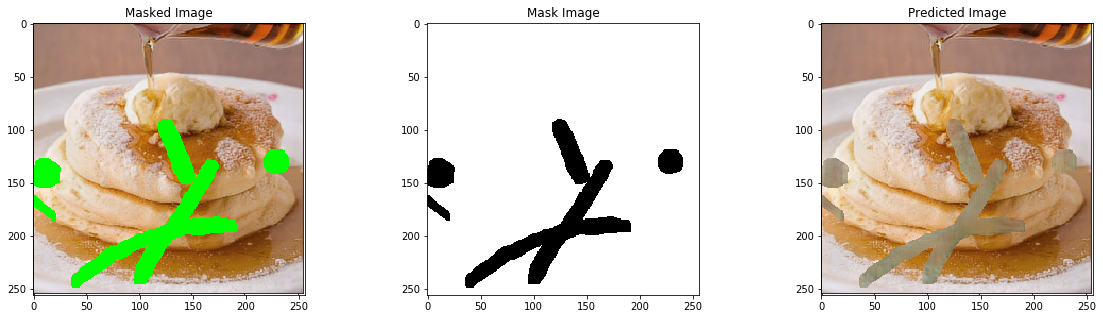

In [0]:
masked_img_path='drive/My Drive/Colab Notebooks/data/pancake_images/maskedpancake7.bmp'
#masked_img_path='drive/My Drive/Colab Notebooks/data/food_images/q_10.bmp'

import skimage.io as ski_io
import skimage.color as ski_color
import skimage.morphology as ski_morph

masked = ski_io.imread(masked_img_path)
to_filling = (masked[:, :, 1] > 245) & (masked[:, :, 0] < 10) & (masked[:, :, 2] < 10)
mask_roi= np.zeros((256, 256, 3), np.uint8)
mask_roi[to_filling] = 1

mask = 1.-mask_roi

erosion_size = 11
erosion_type = 0
val_type = cv2.MORPH_ELLIPSE
element = cv2.getStructuringElement(erosion_type, (2*erosion_size + 1, 2*erosion_size+1), (erosion_size, erosion_size))
erosion_mask = cv2.erode(mask, element)

masked_tmp_list = []
masked_tmp_list.append(masked)
masked_na = np.array(masked_tmp_list)

mask_tmp_list = []
mask_tmp_list.append(erosion_mask)
mask_na = np.array(mask_tmp_list)

model = PConvUnet(weight_filepath='drive/My Drive/Colab Notebooks/data/logs/')
model.load('drive/My Drive/Colab Notebooks/data/logs/533_weights_2019-12-24-01-57-53.h5')

pred_img_set = model.predict([masked_na, mask_na])

pred_img = 255.*pred_img_set[0,:,:,:]

gen_image = masked.copy()
gen_image[to_filling] = pred_img[to_filling]

   

_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(masked[:,:,:])
axes[1].imshow(mask[:,:,:])
axes[2].imshow(pred_img[:,:,:])
axes[2].imshow(erosion_mask[:,:,:])
axes[2].imshow(gen_image[:,:,:])
axes[0].set_title('Masked Image')
axes[1].set_title('Mask Image')
axes[2].set_title('Predicted Image')
plt.show()

In [0]:
import pickle
fname = 'pancake_test2.pickle'
with open(fname,'wb') as f:
  pickle.dump(model,f)
  